# Plot and extract UNIONS tiles that overlap with spectroscopic surveys

In [1]:
import os
import sys
import numpy as np
import pylab as plt
from astropy.io import fits
import cfis

plt.ioff()

## Spectroscopic surveys

### Data directory
The catalogs need to be downloaded from the following URLs beforehand.
The 3DHST survey requires registration before tha data can be accessed.

In [2]:
# Download spectroscopic data:
# - 3DHST (AEGIS and GOODS-N)
#   http://monoceros.astro.yale.edu/RELEASE_V4.1.5/3dhst.v4.1.5.master.fits.gz
#   (Need to first register at https://3dhst.research.yale.edu/signup.php)
# - DEEP2, DEEP3:
#   deep.ps.uci.edu/deep3/zcat_archive/alldeep.egs.uniq.2012jun13.fits.gz
# - SDSS DR12:
#   https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz
# - eBOSS:
#   https://data.sdss.org/sas/dr14/eboss/lss/catalogs/data_DR14_LRG_N.fits

# Download directory
cat_home = '{}/astro/data/CFIS/spectro_surveys'.format(os.environ['HOME'])

### Spectroscopic survey information

In [3]:
class Survey(object):
    """Survey
    Data and information for a spectroscopic survey.
    
    Parameters
    ----------
    name : string
        survey name
    color : string
        plot color
    dec_min : float, optional, default=30
        minimum declination, data with dec<dec_min is cut
    dec_max : float, optional, default=90
        maximum declination, data with dec>dec_max is cut
    """

    def __init__(self, name, color, dec_min=30, dec_max=90):
        
        self.name = name
        self.color = color
        self.dec_min = dec_min
        self.dec_max = dec_max
        
    @classmethod
    def from_fits(cls, name, color, path, key_ra='ra', key_dec='dec', dec_min=30, dec_max=90):
        """Get coordinates from FITS file
        """
        
        dat = fits.open(path)
        ra = dat[1].data[key_ra]
        dec = dat[1].data[key_dec]
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max)
        c.set_coords(ra, dec)
        return c
    
    @classmethod
    def from_array(cls, name, color, ra, dec, dec_min=30, dec_max=90):
        """Get coordinates from arrays
        """
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max)
        c.set_coords(np.array(ra), np.array(dec))
        return c

    def set_coords(self, ra, dec):
        """Set coordinates with cuts (UNIONS footprint)
        """  
        
        # Cut area
        idx1 = (self.dec_min < dec)
        idx2 = (dec < self.dec_max)
        idx = idx1 & idx2
        
        n_tot = len(dec)
        n_UNIONS = len(dec[idx])
        print('{}: {} objects in total, {}/{} = {:.1f}% '
              'potentially in UNIONS footprint'
              ''.format(self.name, n_tot, n_UNIONS, n_tot, n_UNIONS/n_tot*100))
        
        self._ra = ra[idx]
        self._dec = dec[idx]
        
        self._min_ra = min(self._ra)
        self._max_ra = max(self._ra)
        self._min_dec = min(self._dec)
        self._max_dec = max(self._dec)

### Load the spectroscopic survey data
Define the survey specifications, including name, plot color, and coordinate cuts.

In [4]:
surveys = []

# Dummy survey for testing
#surveys.append(Survey.from_array('Test', 'orange',
#                                 [1, 1.1], [29.5, 29.6], dec_min=28))       

surveys.append(Survey.from_fits('3DHST-AEGIS', 'green',
                                '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
                                dec_max=60))

# Goods-North has not yet overlap with UNIONS
surveys.append(Survey.from_fits('3DHST-GOODS-N', 'blue',
                                '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
                                dec_min=60))

surveys.append(Survey.from_fits('DEEP2+3', 'magenta',
                                '{}/alldeep.egs.uniq.2012jun13.fits'.format(cat_home),
                                key_ra='RA', key_dec='dec'))

surveys.append(Survey.from_fits('SDSS', 'grey',
                                '{}/galaxy_DR12v5_CMASSLOWZTOT_North.fits'.format(cat_home),
                                key_ra='RA', key_dec='DEC'))

surveys.append(Survey.from_fits('eBOSS', 'grey',
                                '{}/data_DR14_LRG_N.fits'.format(cat_home),
                                key_ra='RA', key_dec='DEC'))

3DHST-AEGIS: 207967 objects in total, 41200/207967 = 19.8% potentially in UNIONS footprint
3DHST-GOODS-N: 207967 objects in total, 38279/207967 = 18.4% potentially in UNIONS footprint
DEEP2+3: 23822 objects in total, 23822/23822 = 100.0% potentially in UNIONS footprint
SDSS: 953255 objects in total, 424475/953255 = 44.5% potentially in UNIONS footprint
eBOSS: 79770 objects in total, 79770/79770 = 100.0% potentially in UNIONS footprint


## UNIONS/CFIS data

### Set-up
Define optical bands, paths, and load image IDs.

In [5]:
# Variables
unit = 'deg'
image_type = 'tile'
bands = ['u', 'r', 'i', 'z']
colors = ['b', 'r', 'darkred', 'm']

# Padding around search area in plot
d = 0.5

# Input tiles ID files
sp_home = '{}/astro/repositories/github/shapepipe'.format(os.environ['HOME'])
tiles_dir = '{}/aux/CFIS/tiles_202011'.format(sp_home)
tiles_ID = {}
for band in bands:
    tiles_ID[band] = '{}/tiles_{}.txt'.format(tiles_dir, band)
    
# Output tiles ID file base names
tiles_all_ID_base = './tile_{}'.format(''.join(bands))

# Get list of all images
images = {}
for band in bands:
    images[band] = cfis.get_image_list(tiles_ID[band], band, image_type, input_format='ID_only', verbose=True)

27291 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_u.txt'
12621 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_r.txt'
5363 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_i.txt'
5065 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_z.txt'


## Find tiles in overlap area
The area is a rectangle including all spectroscopic objects. The following code finds all images
in that rectangle.

In [6]:
angles = {}
images_overlap = {}
for s in surveys:

    print(s.name)

    # Create area string
    area_str = '{0:.2f}{4}_{1:.2f}{4}_{2:.2f}{4}_{3:.2f}{4}'\
               ''.format(s._min_ra - d,
                         s._min_dec - d,
                         s._max_ra + d,
                         s._max_dec + d,
                         unit)
   
    # Get area coordinates from string
    angles[s.name] = cfis.get_Angle_arr(area_str, num=4)
 
    # Get images in selected area
    images_overlap[s.name] = {}
    for band in bands:
        images_overlap[s.name][band] = cfis.find_images_in_area(images[band],
                                                                angles[s.name], band, image_type)
        print(' {} {}-band images in overlap area found'
              ''.format(len(images_overlap[s.name][band]), band))

3DHST-AEGIS
 0 u-band images in overlap area found
 6 r-band images in overlap area found
 0 i-band images in overlap area found
 0 z-band images in overlap area found
3DHST-GOODS-N
 0 u-band images in overlap area found
 0 r-band images in overlap area found
 0 i-band images in overlap area found
 0 z-band images in overlap area found
DEEP2+3
 0 u-band images in overlap area found
 24 r-band images in overlap area found
 0 i-band images in overlap area found
 0 z-band images in overlap area found
SDSS
 8509 u-band images in overlap area found
 9952 r-band images in overlap area found
 2489 i-band images in overlap area found
 2408 z-band images in overlap area found
eBOSS
 5217 u-band images in overlap area found
 6864 r-band images in overlap area found
 1425 i-band images in overlap area found
 1367 z-band images in overlap area found


## Identify tile IDs for which all multi-band images are present

In [7]:
ID = {}
for s in surveys:
    ID[s.name] = {}
    
    # Get ID strings
    for b in bands:
        ID[s.name][b] = []
        for img in images_overlap[s.name][b]:
            ID[s.name][b].append(img.get_ID())
        
    # Get common elements by using set intersection
    ID[s.name]['all'] = set(ID[s.name][bands[0]])
    for i in range(1, len(bands)):
        ID[s.name]['all'] = ID[s.name]['all'].intersection(ID[s.name][bands[i]])

# Write to text files
for s in surveys:
    if len(ID[s.name]['all']) > 0:
        out_path = '{}_{}.txt'.format(tiles_all_ID_base, s.name)
        f = open(out_path, 'w')
        f.write('\n'.join(ID[s.name]['all']))
        f.close()

## Plotting the sky areas
Create a plot for each spectroscopic survey, showing the spectro objects and UNIONS tiles.

Plotting 3DHST-AEGIS...


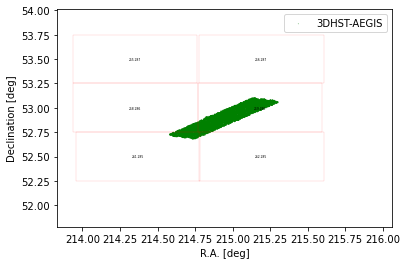

Plotting 3DHST-GOODS-N...


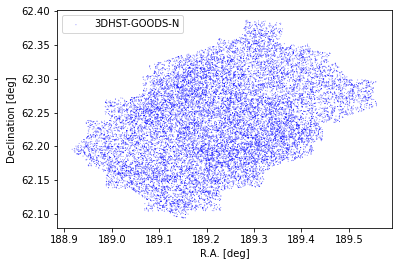

Plotting DEEP2+3...


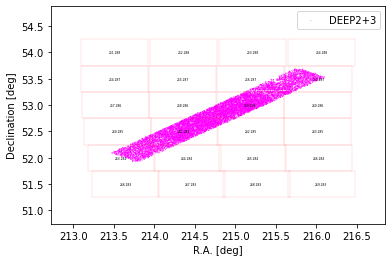

Plotting SDSS...


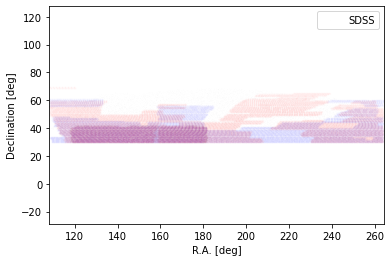

Plotting eBOSS...


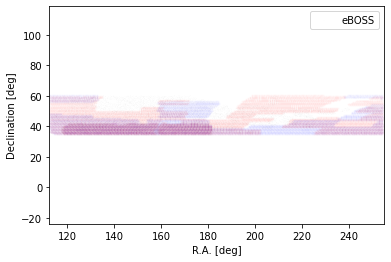

In [9]:
# Max number of spectro objects in plots
n_sp_max = 20000

# If large number of tiles, change plot properties
n_tiles_thres = 100

for s in surveys:
    #if s.name != '3DHST-AEGIS':
    #    continue
    print('Plotting {}...'.format(s.name))
 
    fig, (ax) = plt.subplots()

    # Plot images
    show_numbers = True
    nimg_tot = 0
    dxy = 0
    for band, color in zip(bands, colors):
        nimg = len(images_overlap[s.name][band])
        nimg_tot = nimg + nimg_tot
        if nimg > n_tiles_thres:
            show_numbers = False
            lw = 0.02
        else:
            lw = 0.1
        if nimg > 0:
            dummy = cfis.plot_area(images_overlap[s.name][band], angles[s.name],
                                   image_type, None, False, col=color,
                                   show_circle=False, show_numbers=show_numbers,
                                   ax=ax, dxy=dxy, lw=lw, save=False)
            if show_numbers:
                show_numbers = False
            dxy = dxy + 0.015

    # Plot spectroscopic objects
    if len(s._ra > n_sp_max):
        idx  = np.random.choice(len(s._ra), n_sp_max)
        ra = s._ra[idx]
        dec = s._dec[idx]
    else:
        ra = s._ra
        dec = s._dec
    
    if nimg_tot > n_tiles_thres:
        plt.rcParams['lines.markersize'] = 0.1
    else:
        plt.rcParams['lines.markersize'] = 1
    ax.scatter(ra, dec, marker='o', color=s.color, edgecolors='none',  alpha=0.5, label=s.name)

    plt.xlabel('R.A. [{}]'.format(unit))
    plt.ylabel('Declination [{}]'.format(unit))
    plt.legend(loc='best')
    plt.savefig('{}.pdf'.format(s.name))
    plt.savefig('{}.png'.format(s.name))
    plt.show()